<a href="https://colab.research.google.com/github/imaboylol/cardiology-analysis/blob/main/models/stat_importance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!gdown 10mhkP6VaeBmdwvrk0iEejcYR0192xzWi

Downloading...
From: https://drive.google.com/uc?id=10mhkP6VaeBmdwvrk0iEejcYR0192xzWi
To: /content/ГКМП_df.csv
100% 289k/289k [00:00<00:00, 42.3MB/s]


In [2]:
import warnings
import plotly.graph_objects as go
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from math import sqrt
from scipy.stats import t
from scipy.stats import wilcoxon
from statsmodels.stats.contingency_tables import mcnemar # McNemar's test
import statsmodels.api as sm
import scipy
from scipy import stats as st
from scipy.stats import kstest
from scipy.stats import shapiro
from scipy.stats import anderson, normaltest, mannwhitneyu, chisquare
import graphviz
import seaborn as sns

In [3]:
from IPython.display import SVG
from graphviz import Source
from IPython.display import display

from IPython.display import HTML
style = "<style>svg{width:50% !important;height:100% !important;}</style>"
HTML(style)

In [4]:
import warnings
warnings.filterwarnings("ignore", category=Warning)

In [5]:
df = pd.read_csv('ГКМП_df.csv', sep=";", decimal=',')

In [6]:
clean_df = df[df.iloc[:,0].isin([1, 3])]

In [7]:
# Корректировка некоторых атрибутов
# 'non_zero' - для ненулевого уровня, NaN - для произвольного (пропущенные значеня)

clean_df = clean_df.replace({'Жалобы на боли в области сердца, да - 1, нет - 2':{3:np.nan}})

# Артериальная гипертензия (6,7)
clean_df.loc[(clean_df.iloc[:, 6] == 2.0) & (clean_df.iloc[:, 7].isin([1.0, 2.0, 3.0])), 'Артериальная гипертензия, да - 1, нет - 2'] = 1.0
clean_df.loc[(clean_df.iloc[:, 6] == 2.0) & (clean_df.iloc[:, 7].isna()), 'Степень АГ, 1 ст, - 1, 2 ст, - 2, 3 ст, - 3,'] = 0.0
clean_df.loc[(clean_df.iloc[:, 6] == 1.0) & (clean_df.iloc[:, 7].isna()), 'Степень АГ, 1 ст, - 1, 2 ст, - 2, 3 ст, - 3,'] = 'non_zero'
# print(clean_df.iloc[:, [6, 7]].value_counts())

# Обструкция ЛЖ (15, 17)
clean_df.loc[clean_df.iloc[:, 17] == 4.0, 'Тип обструкции 1- покой, 2-латентная, 3- нет,4-без обструкции в покое,5 - нет данных'] = 3.0
clean_df.loc[(clean_df.iloc[:, 15] == 1.0) & (clean_df.iloc[:, 17] == 3.0), 'Обструкция ЛЖ, есть - 1, нет - 2'] = 2.0
clean_df.loc[(clean_df.iloc[:, 15].isna()) & (clean_df.iloc[:, 17] == 1.0), 'Обструкция ЛЖ, есть - 1, нет - 2'] = 1.0
clean_df.loc[(clean_df.iloc[:, 15].isna()) & (clean_df.iloc[:, 17] == 3.0), 'Обструкция ЛЖ, есть - 1, нет - 2'] = 2.0
clean_df.loc[(clean_df.iloc[:, 15] == 2.0) & (clean_df.iloc[:, 17] == 2.0), 'Обструкция ЛЖ, есть - 1, нет - 2'] = 1.0
clean_df.loc[(clean_df.iloc[:, 15] == 2.0) & (clean_df.iloc[:, 17].isna()),'Тип обструкции 1- покой, 2-латентная, 3- нет,4-без обструкции в покое,5 - нет данных'] = 3.0
clean_df.loc[(clean_df.iloc[:, 15] == 2.0) & (clean_df.iloc[:, 17] == 1.0) & (clean_df.iloc[:, 19] > 30.), 'Обструкция ЛЖ, есть - 1, нет - 2'] = 1.0
clean_df.loc[(clean_df.iloc[:, 15] == 2.0) & (clean_df.iloc[:, 17] == 1.0), ['Обструкция ЛЖ, есть - 1, нет - 2', 'Тип обструкции 1- покой, 2-латентная, 3- нет,4-без обструкции в покое,5 - нет данных']] = np.nan
clean_df.loc[(clean_df.iloc[:, 15].notna()) & (clean_df.iloc[:, 17].isna()), 'Тип обструкции 1- покой, 2-латентная, 3- нет,4-без обструкции в покое,5 - нет данных'] = 'non_zero'
# clean_df.iloc[:, [15, 17]].value_counts()

# Митральная регургитация (25, 26)
clean_df.loc[(clean_df.iloc[:, 25].isna()) & (clean_df.iloc[:, 26].notna()), 'Митральная регургитация, да - 1, нет - 2'] = 1.0
clean_df.loc[(clean_df.iloc[:, 25] == 1.0) & (clean_df.iloc[:, 26].isna()), 'Степень МР'] = 'non_zero'
clean_df.loc[(clean_df.iloc[:, 25] == 2.0) & (clean_df.iloc[:, 26].isna()), 'Степень МР'] = 0.0
# clean_df.iloc[:, [25, 26]].value_counts()

# Диастолическая дисфункция (27)
clean_df.loc[clean_df.iloc[:, 27] == 5.0, 'Диастолическая дисфункция, нет - 5, 1 степени - 1, 2 - 2, 3 - 3, 4-без степени,6-нет даных'] = 0.0
clean_df.loc[clean_df.iloc[:, 27] == 4.0, 'Диастолическая дисфункция, нет - 5, 1 степени - 1, 2 - 2, 3 - 3, 4-без степени,6-нет даных'] = 'non_zero'
# clean_df.iloc[:, 27].value_counts()

# Митральный клапан (37)
# clean_df.loc[clean_df.iloc[:, 37] == 3, 'Митральный клапан N-1,недостаточность-2,стеноз-3,комбинация-4,5-нет данных'] = np.nan

clean_df = clean_df.replace('non_zero', np.nan)

In [8]:
clean_df.columns[14]

'Максимальная толщина стенки левого желудочка (мм)'

In [9]:
# Под вопросом: 43
drop_columns = [2, 6, 15, 16, 18, 20, 25, 38, 39, 41, 42,
                43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 55, 57, 58,
                62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 74]
clean_df = clean_df.drop(clean_df.columns[drop_columns], axis=1)

In [10]:
rename_columns_dict = {
    'Максимальная толщина стенки левого желудочка (мм)':'Max_left_vent_wall_width',
    'Группа 1 - подходит по критериям ГКМП, 2 - "серая зона", 3 - не подходит, 4 - оперированный пациент, 5 - беременная, 6 - дети до 18 лет, 7 - нет данных':'HCM',
    'Пол (1-м, 2-ж)':'Sex',
    'Возраст на момент регистрации пациенат в системе':'Age',
    'Жалобы на одышку, да - 1, нет - 2':'Dyspnoea_complaints',
    'Жалобы на боли в области сердца, да - 1, нет - 2':'Chest_pain_complaints',
    'Степень АГ, 1 ст, - 1, 2 ст, - 2, 3 ст, - 3,':'Hypertension_grade',
    'Жалобы на перебои в работе сердца, да - 1, нет - 2':'Arrhythmia_complaints',
    'Жалобы на синкопальные состояния, 1 - нет, 2 - пресинкопальные, 3 - синкопальные':'Syncope_complaints',
    'Жалобы на отеки нижних конечностей, да - 1, нет - 2':'Peripheral_oedema_complaints',
    'Внезапная сердечная смерть в анамнезе заболевания, есть - 1, нет - 2':'Sudden_cardiac_death_anamnesis',
    'Внезапная сердечная смерть у родственников 1й линии родства (до 40 лет без установленного диагноза и в любом возрасте если был диагноз ГКМП), есть - 1, нет - 2':'Sudden_cardiac_death_relatives',
    'Анамнез ГКМП в семье, 2 - нет, есть - 1':'Familial_HCM',
    'Тип обструкции 1- покой, 2-латентная, 3- нет,4-без обструкции в покое,5 - нет данных':'Left_ventricular_obstruction',
    'Макс, градиент покоя':'Max_gradient_rest',
    'Макс,градиент при провокации':'Max_gradient_provocation',
    'Размер левого предсердия (передне-задний диаметр,)':'Left_atrium_antero_posterior_diameter',
    'Объем левого предсердия (индексированный)':'Left_atrium_indexed_volume',
    'Передне-систолическое движение створки, есть - 1, нет - 2':'Mitral_valve_systolic_anterior_motion',
    'Степень МР':'Mitral_regurgitation_severity',
    'Диастолическая дисфункция, нет - 5, 1 степени - 1, 2 - 2, 3 - 3, 4-без степени,6-нет даных':'Diastolic_dysfunction_grade',
    'КДР, мм':'End_diastolic_dimension',
    'КСР, мм':'End_systolic_dimension',
    'КДО, мл':'End_diastolic_volume',
    'КСО, мл':'End_systolic_volume',
    'ФВ (S)':'Ejection_fraction',
    'Систолическое давление в ЛА, мм рт,ст,':'Рulmonary_artery_systolic_pressure',
    'ПЖ размер, 4 камерная, мм':'Right_ventricle_size_four_chambers',
    'ПЖ размер,парастернальная, мм':'Right_ventricle_size_parasternal',
    'Толщна стенки ПЖ, мм':'Right_ventricle_wall_thickness',
    'Митральный клапан N-1,недостаточность-2,стеноз-3,комбинация-4,5-нет данных':'Mitral_valve',
    'Аортальный клапан N-1,недостаточность-2,стеноз-3,комбинация-4,5-нет данных':'Aortic_valve',
    'Ширина комплекса QRS, менее 120 мсек - 2, более 120 мсек - 1':'QRS_duration',
    'Патологический зубец Q, нет - 2, да - 1':'Pathological_Q_wave',
    'Наличие ФП, да - 1, нет - 2':'Atrial_fibrillation',
    'Наличие сахарного диабета, нет - 4, второй тип - 1, НТГ - 2, первый тип - 3':'Diabetes',
    'Желудочковая тахикардия, нет - 3, неустойчивая - 1, устойчивая - 2':'Ventricular_tachycardia',
    'АВ блокада, нет - 5, первой степени - 1, второй степени Мобитц один - 2, 3 степени - 3, 2 степени Мобитц 2 - 4':'Atrioventricular_block',
    'ИБС (1- нет, 2 - стенокардия, 3 - ПИКС, 4 - ПИКС и стенокардия, 5 -прочее)':'Coronary_heart_disease'
}

In [11]:
clean_df = clean_df.rename(columns=rename_columns_dict)

In [12]:
rename_values_dict = {
    'HCM':{1:'да', 2:'серая зона', 3:'нет'},
    'Sex':{1:'м', 2:'ж'},
    'Dyspnoea_complaints':{1:'да', 2:'нет'},
    'Chest_pain_complaints':{1:'да', 2:'нет'},
    'Arrhythmia_complaints':{1:'да', 2:'нет'},
    'Syncope_complaints':{1:'нет', 2:'пресинкопальные', 3:'синкопальные'},
    'Peripheral_oedema_complaints':{1:'да', 2:'нет'},
    'Sudden_cardiac_death_anamnesis':{1:'есть', 2:'нет'},
    'Sudden_cardiac_death_relatives':{1:'есть', 2:'нет'},
    'Familial_HCM':{1:'есть', 2:'нет'},
    'Left_ventricular_obstruction':{1:'покой', 2:'латентная', 3:'нет'},
    'Mitral_valve_systolic_anterior_motion':{1:'есть', 2:'нет'},
    'Mitral_valve':{1:'норма', 2:'недостаточность', 3:'стеноз', 4:'комбинация'},
    'Aortic_valve':{1:'норма', 2:'недостаточность', 3:'стеноз', 4:'комбинация'},
    'QRS_duration':{1:'более 120 мсек', 2:'менее 120 мсек'},
    'Pathological_Q_wave':{1:'да', 2:'нет'},
    'Atrial_fibrillation':{1:'да', 2:'нет'},
    'Diabetes':{1:'второго типа', 2:'НГТ', 3:'первого типа', 4:'нет'},
    'Ventricular_tachycardia':{1:'устойчивая', 2:'неустойчивая', 3:'нет'},
    'Atrioventricular_block':{1:'первой степени', 2:'второй степени Мобитц 1', 3:'третьей степени', 4:'второй степени Мобитц 2', 5:'нет'},
    'Coronary_heart_disease':{1:'нет', 2:'стенокардия', 3:'ПИКС', 4:'стенокардия+ПИКС', 5:'прочее'}
}

In [13]:
clean_df = clean_df.replace(rename_values_dict)
clean_df = clean_df.replace({'Atrioventricular_block':{'нет':0, 'первой степени':1, 'второй степени Мобитц 1':2, 'второй степени Мобитц 2':2, 'третьей степени':3}})

In [14]:
# for i in range(clean_df.shape[1]):
#     print(i, clean_df.columns[i])
#     print('Procent of missed values: ', 100*clean_df.iloc[:,i].isnull().sum()/clean_df.shape[0])
#     print('Number of unique values: ', clean_df.iloc[:,i].nunique())
#     if(clean_df.iloc[:,i].nunique() <= 8):
#         print('Unique values: ', clean_df.iloc[:,i].unique())
#         print(clean_df.iloc[:,i].value_counts())
#     print('\n')

In [15]:
numerical_features = ['Age',
                    #'Max_gradient_rest',
                    #'Max_gradient_provocation',
                    'Left_atrium_antero_posterior_diameter',
                    'Left_atrium_indexed_volume',
                    'End_diastolic_dimension',
                    'End_systolic_dimension',
                    'End_diastolic_volume',
                    'End_systolic_volume',
                    'Ejection_fraction',
                    'Рulmonary_artery_systolic_pressure',
                    'Right_ventricle_size_four_chambers',
                    'Right_ventricle_size_parasternal',
                    'Right_ventricle_wall_thickness'
                   ]

categorical_features = ['Sex',
                    #'Dyspnoea_complaints',
                    #'Chest_pain_complaints',
                    #'Arrhythmia_complaints',
                    #'Syncope_complaints',
                    #'Peripheral_oedema_complaints',
                    'Sudden_cardiac_death_anamnesis',
                    'Sudden_cardiac_death_relatives',
                    'Familial_HCM',
                    'Mitral_valve_systolic_anterior_motion',
                    'Mitral_valve',
                    'Aortic_valve',
                    'QRS_duration',
                    'Pathological_Q_wave',
                    'Atrial_fibrillation',
                    'Diabetes',
                    'Ventricular_tachycardia',
                    'Left_ventricular_obstruction',
                    'Coronary_heart_disease',
                   ]

ordinal_features = ['Hypertension_grade',
                    'Mitral_regurgitation_severity',
                    'Diastolic_dysfunction_grade',
                    'Atrioventricular_block'
                   ]

target = 'HCM'

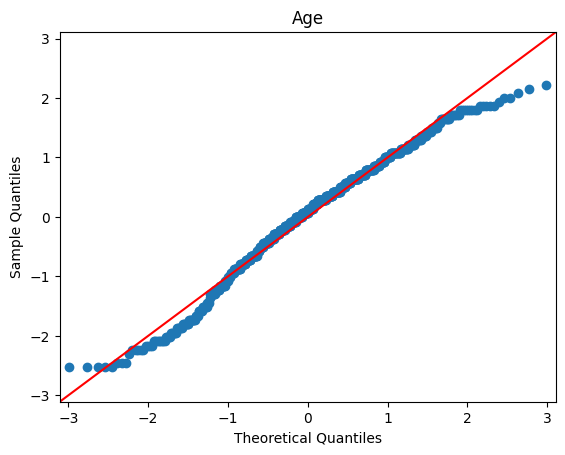

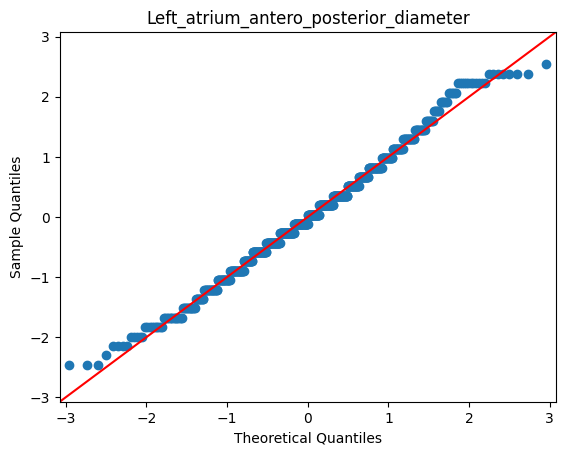

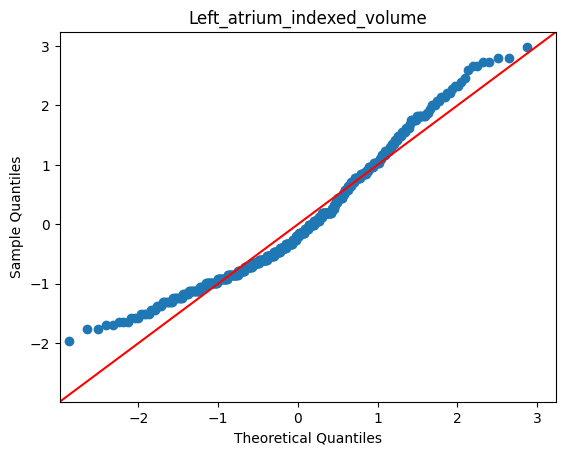

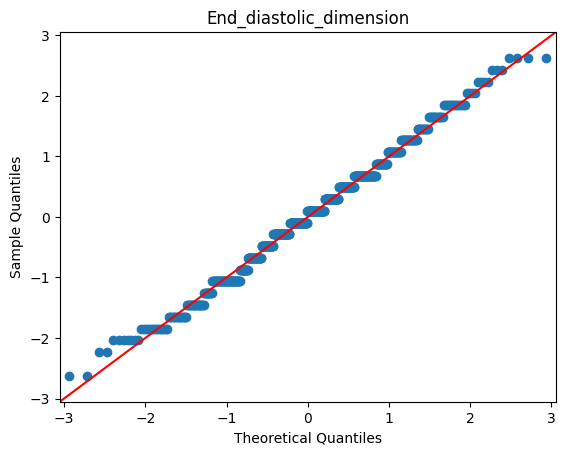

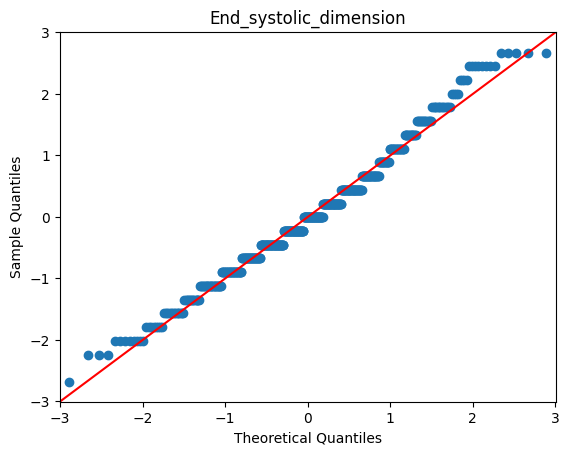

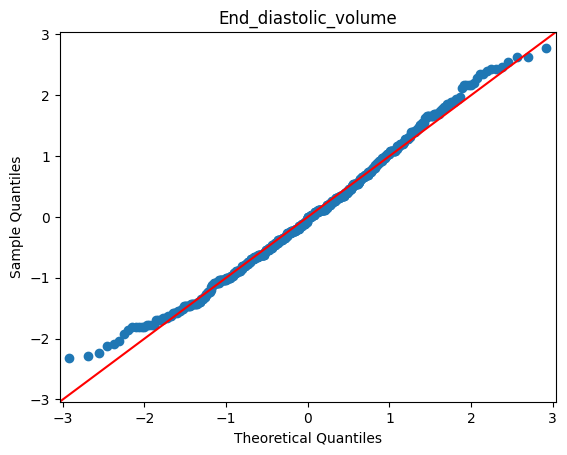

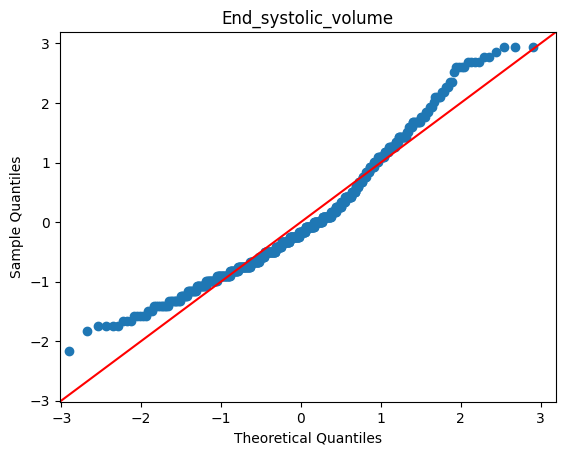

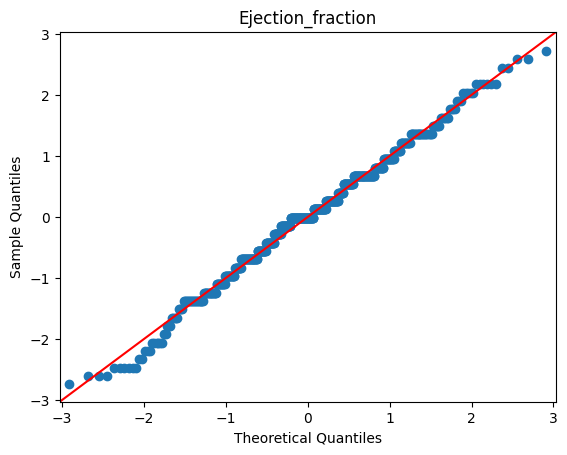

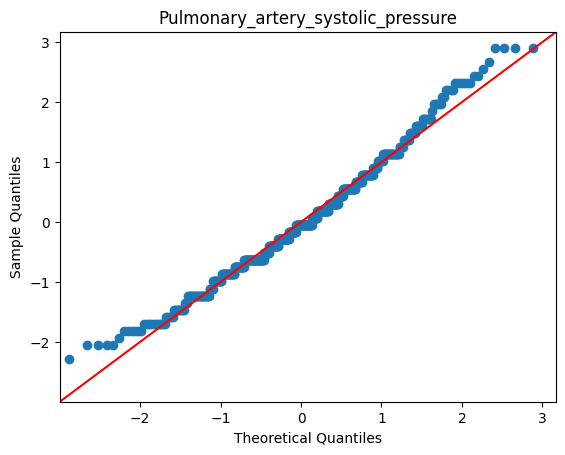

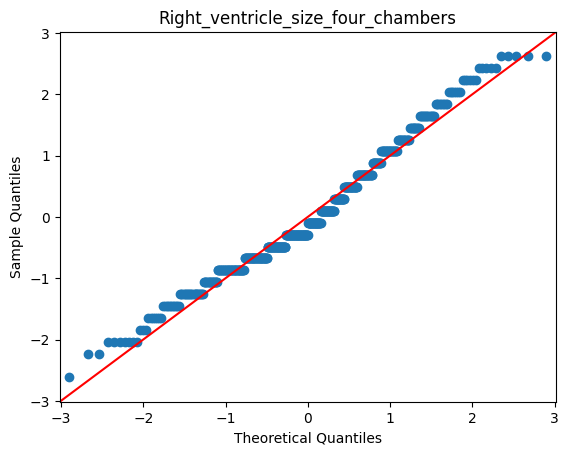

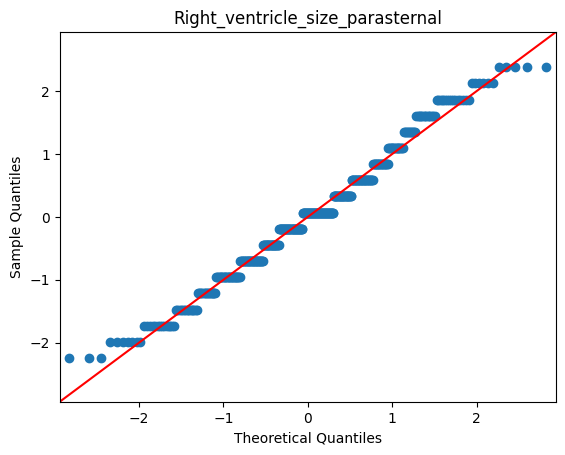

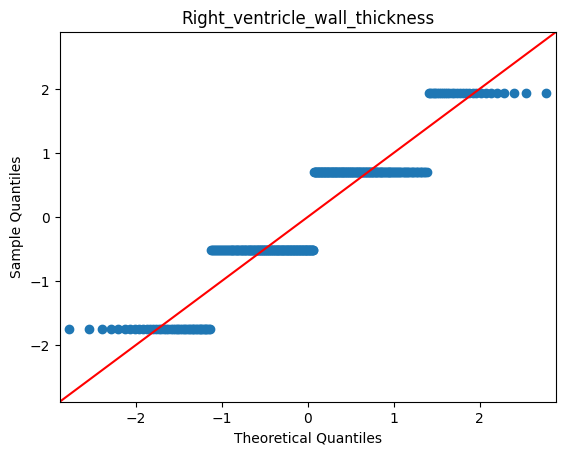

In [16]:
# QQ plots
for column in clean_df[numerical_features].columns:
    edv = clean_df[column].dropna()
    Q1 = edv.quantile(0.25)
    Q3 = edv.quantile(0.75)
    IQR = Q3 - Q1
    new = edv[~((edv < (Q1 - 1.5 * IQR)) | (edv > (Q3 + 1.5 * IQR)))]
    sm.qqplot(new, line='45', fit=True)
    plt.title(column)

plt.show()

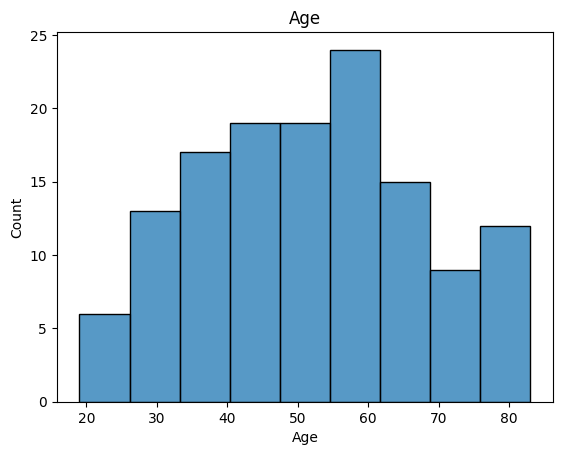

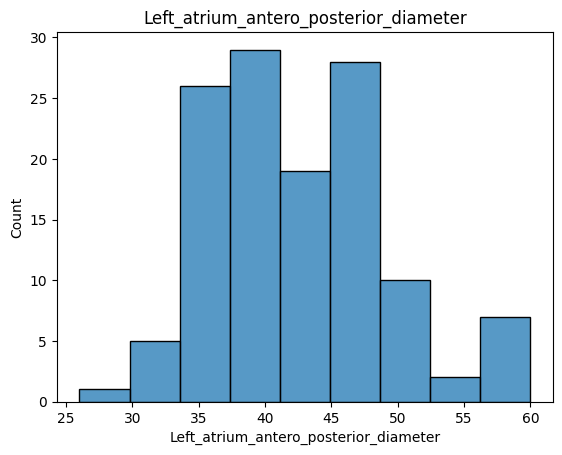

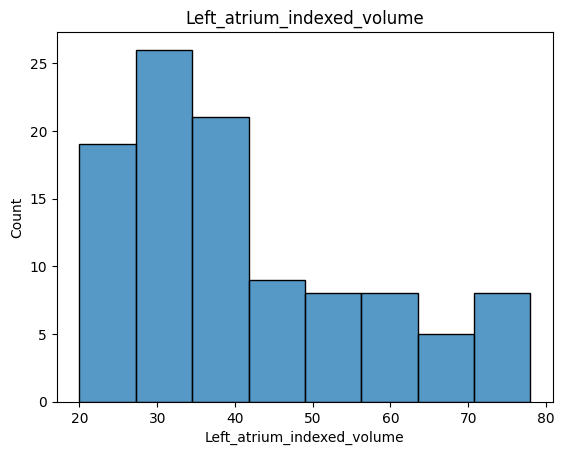

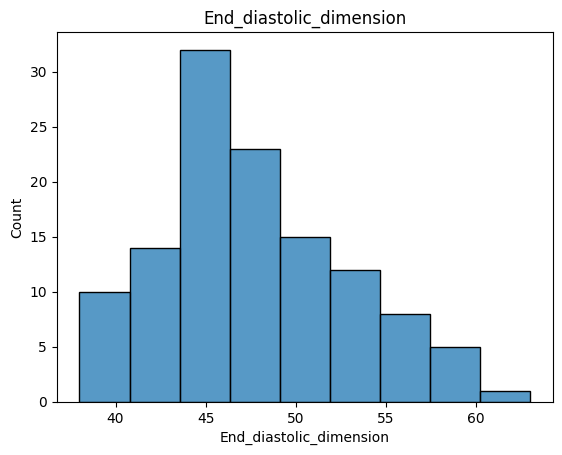

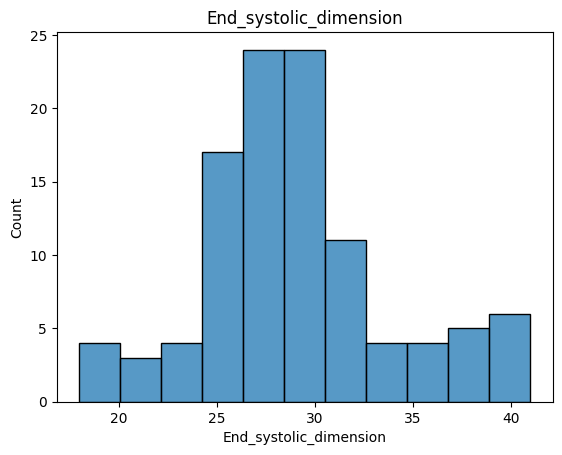

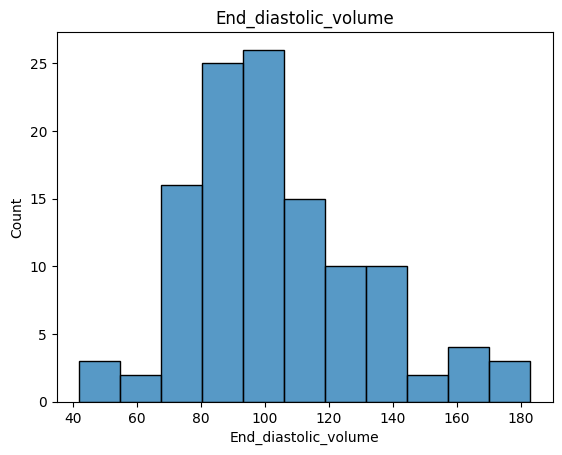

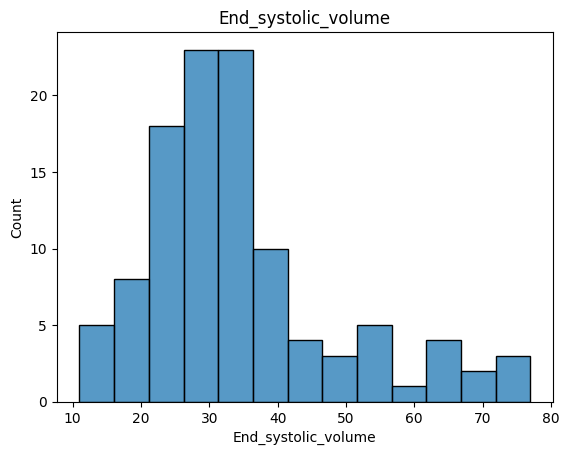

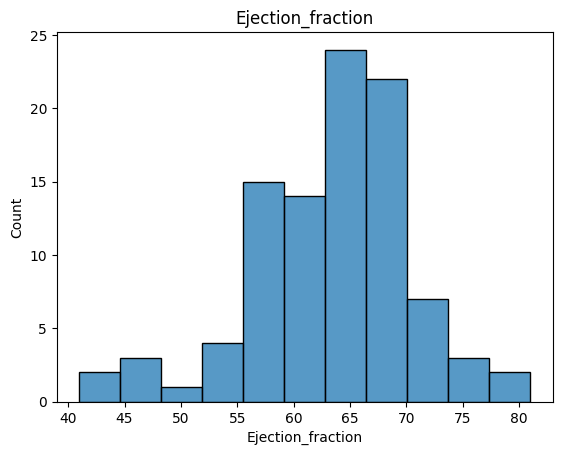

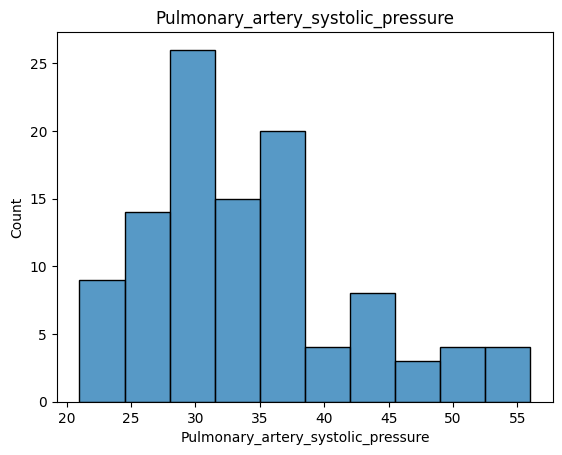

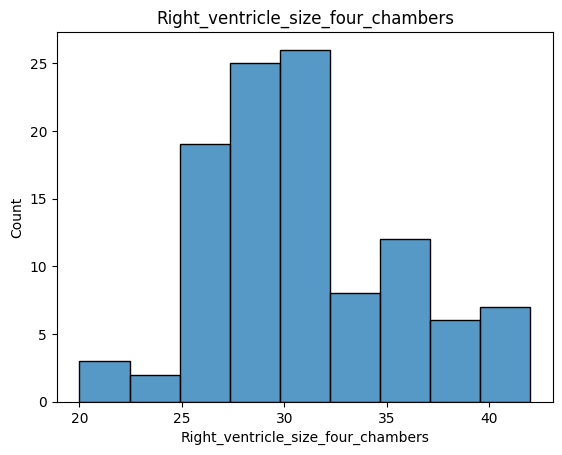

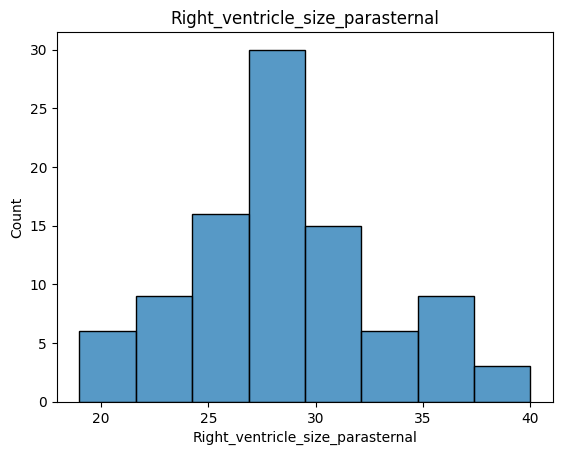

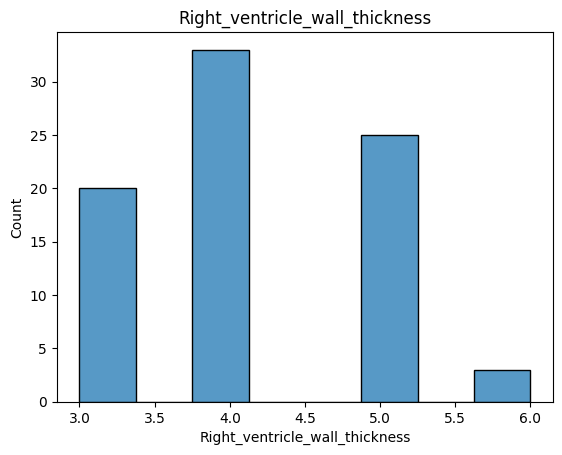

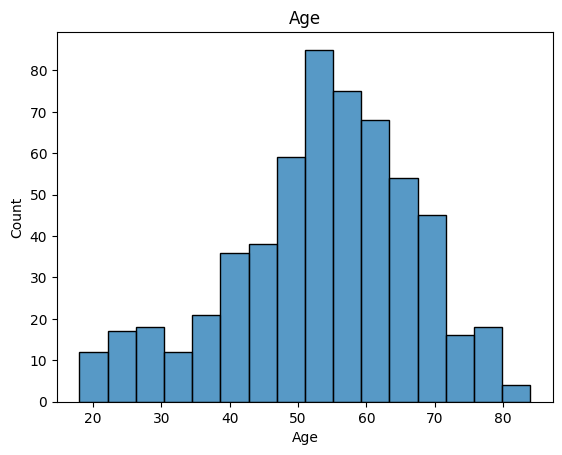

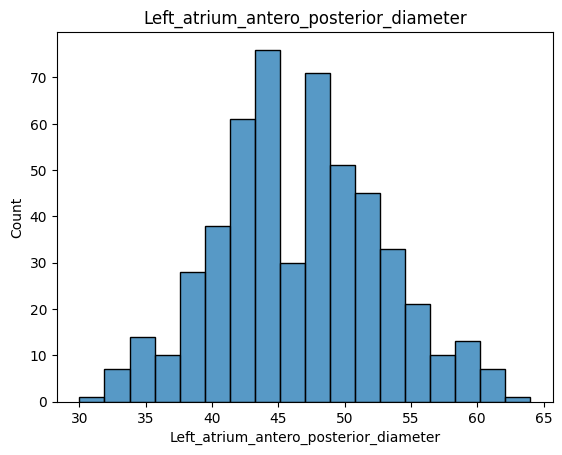

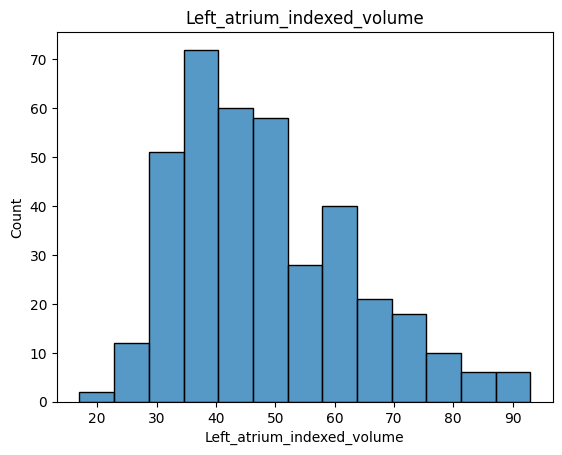

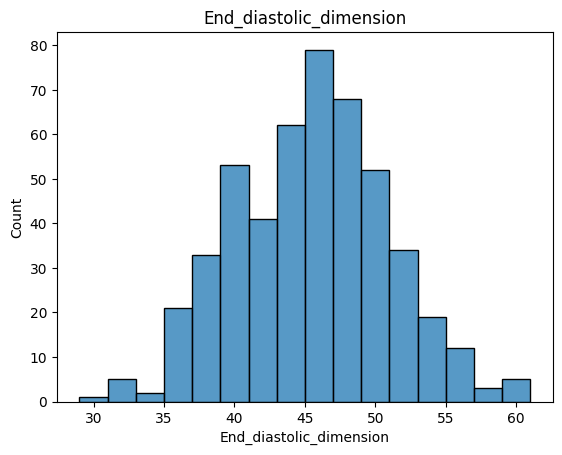

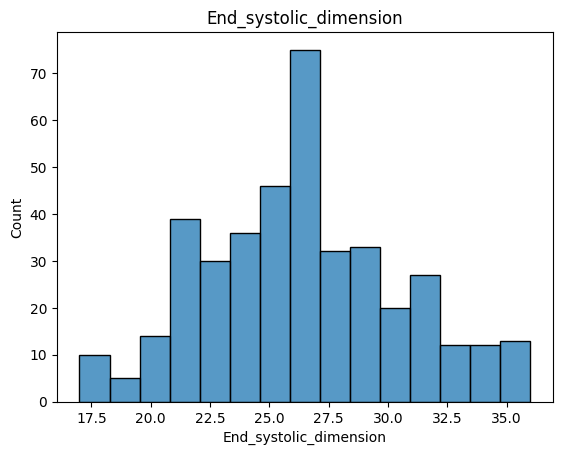

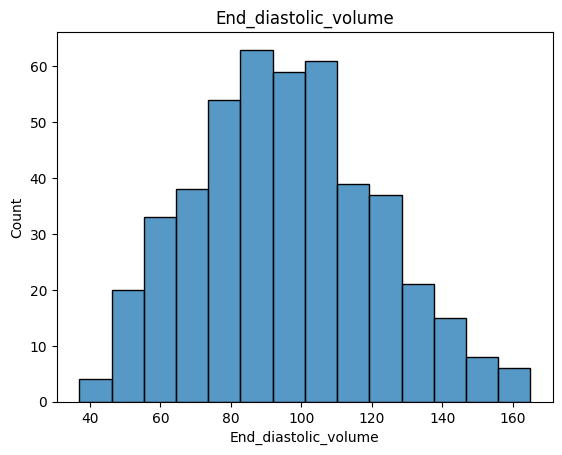

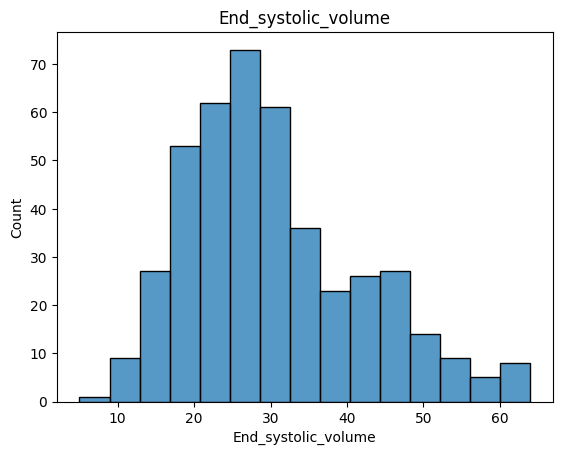

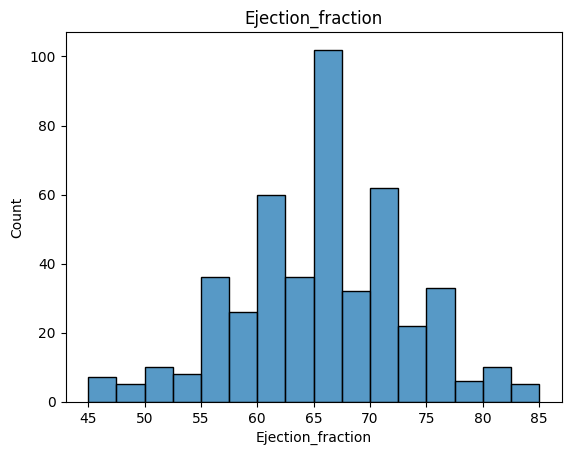

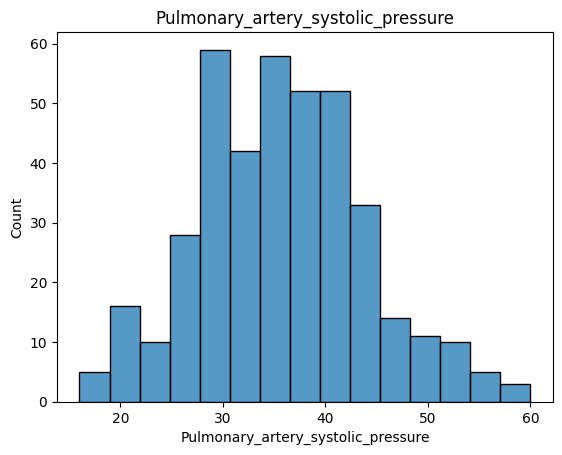

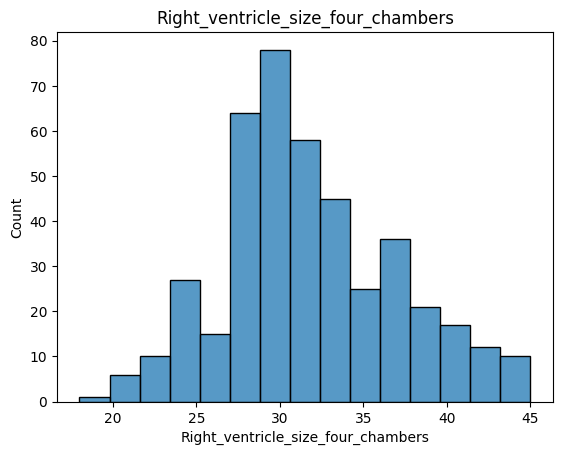

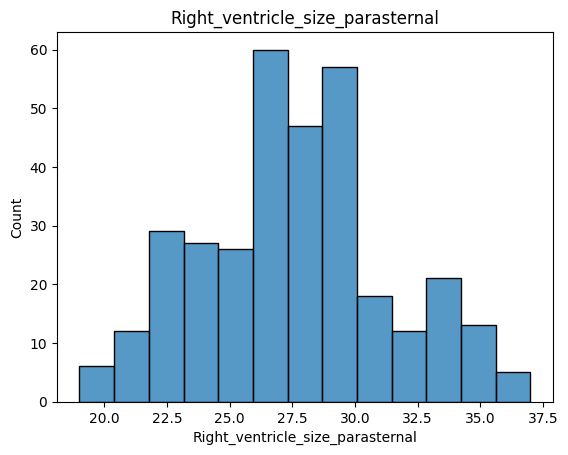

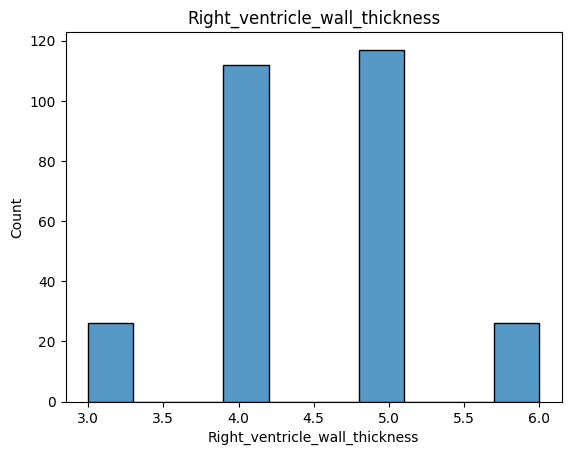

In [17]:
# Histograms
for column in numerical_features:
    edv = clean_df[clean_df['HCM']=='нет'][column].dropna()
    Q1 = edv.quantile(0.25)
    Q3 = edv.quantile(0.75)
    IQR = Q3 - Q1
    new = edv[~((edv < (Q1 - 1.5 * IQR)) | (edv > (Q3 + 1.5 * IQR)))]
    sns.histplot(new)
    plt.title(column)
    plt.show()

for column in numerical_features:
    edv = clean_df[clean_df['HCM']=='да'][column].dropna()
    Q1 = edv.quantile(0.25)
    Q3 = edv.quantile(0.75)
    IQR = Q3 - Q1
    new = edv[~((edv < (Q1 - 1.5 * IQR)) | (edv > (Q3 + 1.5 * IQR)))]
    sns.histplot(new)
    plt.title(column)
    plt.show()

## numerical

In [18]:
def q1(x):
    return x.quantile(0.25)

def q3(x):
    return x.quantile(0.75)

In [19]:
arrays = [
    ["HCM", "HCM", "HCM", "HCM", "HCM", "nonHCM", "nonHCM", "nonHCM", "nonHCM", "nonHCM"],
    ["mean", "SD", "median", "Q1", "Q3", "mean", "SD", "median", "Q1", "Q3"],
]
tuples = list(zip(*arrays))

index = pd.MultiIndex.from_tuples(tuples)

df1 = pd.DataFrame(columns=index)
df1.insert(0, 'Name', [])
df1.insert(df1.shape[1], 'p_value', [])
df1.Name = numerical_features

In [20]:
HCM_df = clean_df[clean_df['HCM']=='да']
nonHCM_df = clean_df[clean_df['HCM']=='нет']
p_vals = []
counter = 0
for column in clean_df[numerical_features].columns:
    col = HCM_df[column].dropna()
    Q1 = col.quantile(0.25)
    Q3 = col.quantile(0.75)
    IQR = Q3 - Q1
    noOutliers_HCM_df = col[~((col < (Q1 - 1.5 * IQR)) | (col > (Q3 + 1.5 * IQR)))]

    col = nonHCM_df[column].dropna()
    Q1 = col.quantile(0.25)
    Q3 = col.quantile(0.75)
    IQR = Q3 - Q1
    noOutliers_nonHCM_df = col[~((col < (Q1 - 1.5 * IQR)) | (col > (Q3 + 1.5 * IQR)))]

    df1["HCM", "mean"].loc[counter] = noOutliers_HCM_df.mean().round(decimals=3)
    df1["HCM", "SD"].loc[counter] = round(noOutliers_HCM_df.std(), 3)
    df1["HCM", "median"].loc[counter] = round(noOutliers_HCM_df.median(), 3)
    df1["HCM", "Q1"].loc[counter] = q1(noOutliers_HCM_df).round(decimals=3)
    df1["HCM", "Q3"].loc[counter] = q3(noOutliers_HCM_df).round(decimals=3)

    df1["nonHCM", "mean"].loc[counter] = noOutliers_nonHCM_df.mean().round(decimals=3)
    df1["nonHCM", "SD"].loc[counter] = round(noOutliers_nonHCM_df.std(), 3)
    df1["nonHCM", "median"].loc[counter] = round(noOutliers_nonHCM_df.median(), 3)
    df1["nonHCM", "Q1"].loc[counter] = q1(noOutliers_nonHCM_df).round(decimals=3)
    df1["nonHCM", "Q3"].loc[counter] = q3(noOutliers_nonHCM_df).round(decimals=3)


    p_vals.append(mannwhitneyu(noOutliers_HCM_df, noOutliers_nonHCM_df).pvalue)

    counter += 1

df1.p_value = p_vals
df1.p_value = df1.p_value.round(decimals=3)

In [21]:
df1

Name     HCM                        \
                                             mean      SD median     Q1   
0                                     Age  53.434  13.566   55.0   45.0   
1   Left_atrium_antero_posterior_diameter   46.53   6.114   46.0   43.0   
2              Left_atrium_indexed_volume  48.521  14.862   46.0   37.0   
3                 End_diastolic_dimension  45.002   5.392   45.0   41.0   
4                  End_systolic_dimension  26.369   4.072   26.0   24.0   
5                    End_diastolic_volume  95.727  25.819   94.0  77.25   
6                     End_systolic_volume  30.323  11.723   28.0   22.0   
7                       Ejection_fraction  65.333    7.44   65.0   60.0   
8      Рulmonary_artery_systolic_pressure  35.714   8.347   35.0   30.0   
9      Right_ventricle_size_four_chambers  31.685   5.255   31.0   28.0   
10       Right_ventricle_size_parasternal  27.631   3.787   28.0   25.0   
11         Right_ventricle_wall_thickness   4.509   0.789    5.0    4.0   

             nonHCM                               p_value  
        Q3     mean      SD median     Q1      Q3          
0     63.0    51.56  15.316   52.0  39.25    62.0   0.110  
1     51.0   42.425   6.806   42.0   37.5    47.0   0.000  
2     59.0   41.644  15.624   37.5  30.75   50.75   0.000  
3     49.0   47.742   5.219   47.0   44.0    51.0   0.000  
4     29.0   29.104   4.757   29.0   26.0    31.0   0.000  
5   112.75  103.621  27.695   99.5  85.75  118.25   0.014  
6     37.0   34.321  14.133   32.0   25.0    38.0   0.005  
7     70.0   63.443   7.271   65.0   59.0    68.0   0.061  
8     41.0   33.757   8.199   33.0   28.0    37.0   0.005  
9     35.0    30.75   4.715   30.0   28.0    34.0   0.085  
10    30.0   28.457   4.632   28.0   25.0   31.75   0.186  
11     5.0    4.136   0.833    4.0    4.0     5.0   0.001

In [22]:
df1.to_excel('NumericalData.xlsx', sheet_name='Лист 1')

## categorical + ordinal

In [23]:
categorical_features = ['Sex',
                    #'Dyspnoea_complaints',
                    #'Chest_pain_complaints',
                    #'Arrhythmia_complaints',
                    #'Syncope_complaints',
                    #'Peripheral_oedema_complaints',
                    #'Sudden_cardiac_death_anamnesis',
                    'Sudden_cardiac_death_relatives',
                    'Familial_HCM',
                    'Mitral_valve_systolic_anterior_motion',
                    'Mitral_valve',
                    'Aortic_valve',
                    'Aortic_valve_grouped',
                    'QRS_duration',
                    'Pathological_Q_wave',
                    'Atrial_fibrillation',
                    'Diabetes',
                    'Ventricular_tachycardia',
                    'Left_ventricular_obstruction',
                    'Coronary_heart_disease',
                    'Right_ventricle_wall_thickness_GreaterEqual_5'
                   ]
ordinal_features = ['Hypertension_grade',
                    'Mitral_regurgitation_severity',
                    'Diastolic_dysfunction_grade',
                    'Atrioventricular_block'
                   ]

In [24]:
grouped_df = clean_df.copy()
grouped_df['Mitral_valve'].replace(['недостаточность', 'комбинация', 'стеноз'], 'не норма', inplace=True)
grouped_df['Ventricular_tachycardia'].replace(['устойчивая', 'неустойчивая'], 'есть', inplace=True)
grouped_df['Aortic_valve_grouped'] = grouped_df['Aortic_valve'].replace(['недостаточность', 'комбинация', 'стеноз'], 'не норма')

grouped_df['Right_ventricle_wall_thickness_GreaterEqual_5'] = np.where(grouped_df.Right_ventricle_wall_thickness >= 5, 'да', 'нет')
grouped_df['Right_ventricle_wall_thickness_GreaterEqual_5'][grouped_df['Right_ventricle_wall_thickness'].isna()] = np.nan

In [25]:
cat_df = pd.DataFrame(columns=['Name', 'HCM', 'nonHCM', 'p_value'])
cat_df['Name'] = categorical_features+ordinal_features
p_vals = []
counter = 0
cat_df['Name'] = cat_df['Name'].astype(str) + ': '

for column in grouped_df[categorical_features+ordinal_features].columns:
    count_df = grouped_df.groupby('HCM', as_index=False)[column].value_counts(sort=False)
    keys = count_df[column].unique().tolist()
    observed = np.reshape(count_df['count'], (2,-1))
    observed_proc = np.reshape(
        (100 * grouped_df.groupby('HCM', as_index=False)[column].value_counts(normalize=True, sort=False)['proportion']).round().astype(int),
        (2,-1)
    )

    cat_df['Name'][counter] = cat_df['Name'][counter] + str(keys)
    cat_df['HCM'].loc[counter] = str(observed[0].tolist()) + ' (' + str(observed_proc[0].tolist()) + ')'
    cat_df['nonHCM'].loc[counter] = str(observed[1].tolist()) + ' (' + str(observed_proc[1].tolist()) + ')'

    row_totals = np.array([np.sum(observed, axis=1)])
    col_totals = np.array([np.sum(observed, axis=0)])
    n = np.sum(observed)
    # Calculate the expected observations
    expected = np.dot(row_totals.T, col_totals) / n
    # Calculate the chi-square test statistic
    chisq, p_value = st.chisquare(observed, expected)
    # Sum the answers
    chisq = np.sum(chisq)
    # Degrees of freedom
    rows = observed.shape[0]
    cols = observed.shape[1]
    dof = (rows - 1) * (cols - 1)
    # Convert chi-square test statistic to p-value
    p_value = 1 - st.chi2.cdf(chisq, dof)
    cat_df['p_value'].loc[counter] = p_value

    counter += 1

cat_df.p_value = cat_df.p_value.astype(float).round(decimals=3)

In [26]:
cat_df

,Name,HCM,nonHCM,p_value
0,"Sex: ['ж', 'м']","[288, 290] ([50, 50])","[74, 60] ([55, 45])",0.260
1,"Sudden_cardiac_death_relatives: ['есть', 'нет']","[20, 472] ([4, 96])","[3, 100] ([3, 97])",0.581
2,"Familial_HCM: ['есть', 'нет']","[36, 456] ([7, 93])","[3, 100] ([3, 97])",0.101
3,Mitral_valve_systolic_anterior_motion: ['есть'...,"[275, 186] ([60, 40])","[11, 93] ([11, 89])",0.000
4,"Mitral_valve: ['не норма', 'норма']","[423, 112] ([79, 21])","[80, 49] ([62, 38])",0.000
5,"Aortic_valve: ['комбинация', 'недостаточность'...","[7, 79, 438, 11] ([1, 15, 82, 2])","[3, 3, 119, 4] ([2, 2, 92, 3])",0.001
6,"Aortic_valve_grouped: ['не норма', 'норма']","[97, 438] ([18, 82])","[10, 119] ([8, 92])",0.004
7,"QRS_duration: ['более 120 мсек', 'менее 120 мс...","[61, 217] ([22, 78])","[6, 43] ([12, 88])",0.121
8,"Pathological_Q_wave: ['да', 'нет']","[14, 326] ([4, 96])","[4, 65] ([6, 94])",0.535
9,"Atrial_fibrillation: ['да', 'нет']","[130, 439] ([23, 77])","[25, 109] ([19, 81])",0.293


In [27]:
cat_df.to_excel('CategoricalData.xlsx', index=False, sheet_name='Лист 1')

In [28]:
numerical_features.append('Max_left_vent_wall_width')

<Axes: >

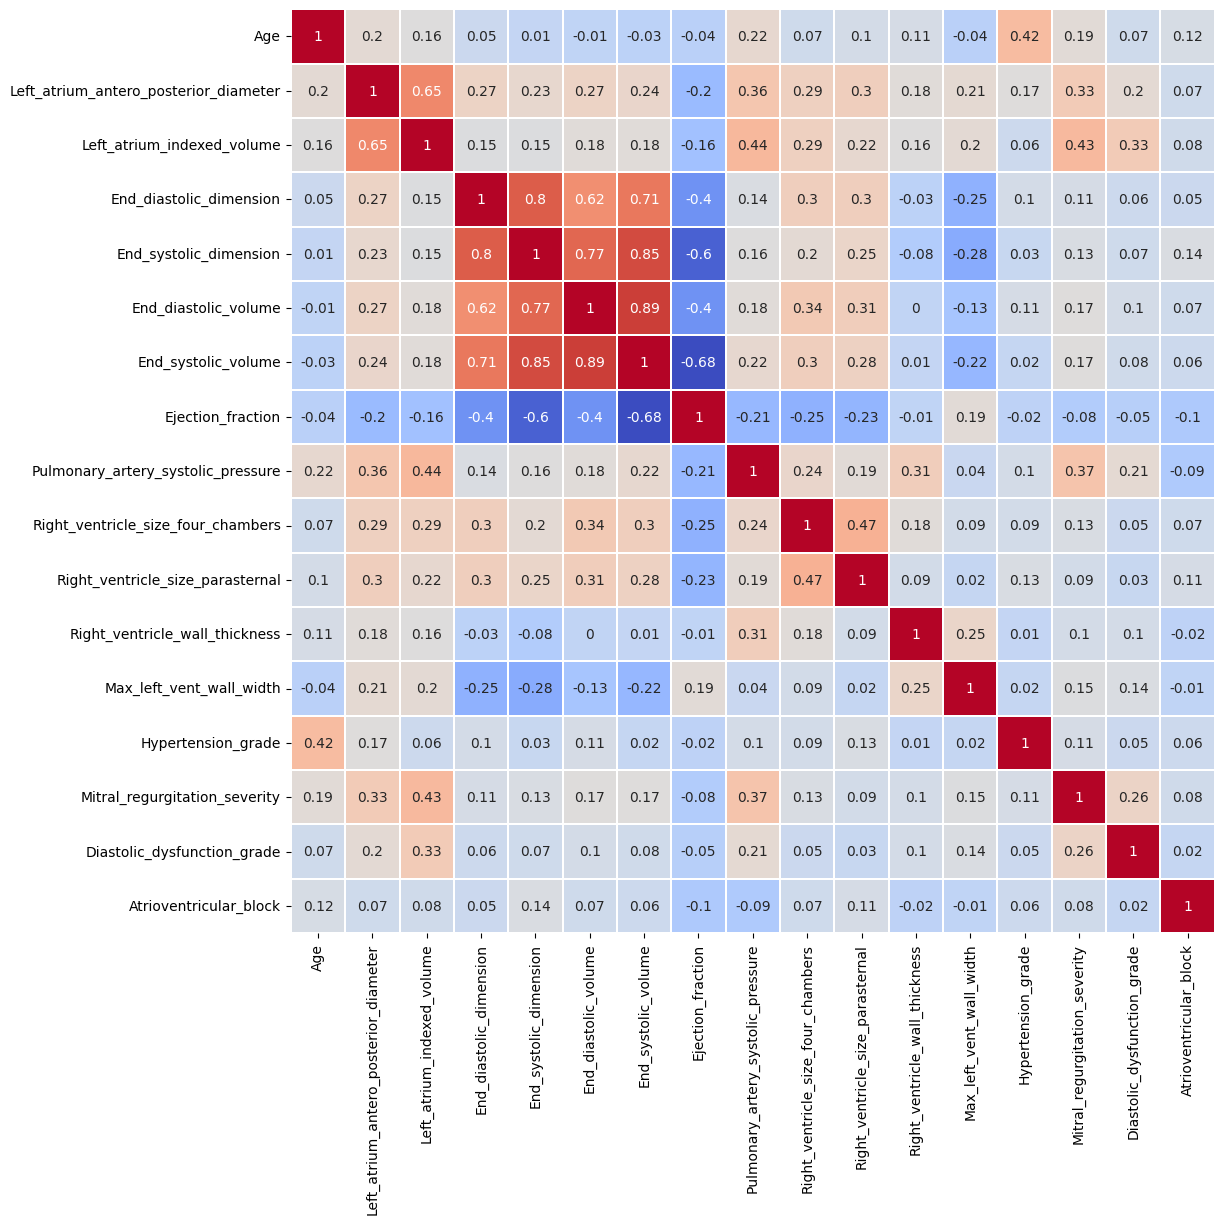

In [29]:
fig, ax = plt.subplots(figsize=(12,12))
sns.heatmap(round(clean_df[numerical_features+ordinal_features].corr(),2), annot=True, linewidths=.1, square=True, cmap="coolwarm", cbar=False)

<Axes: >

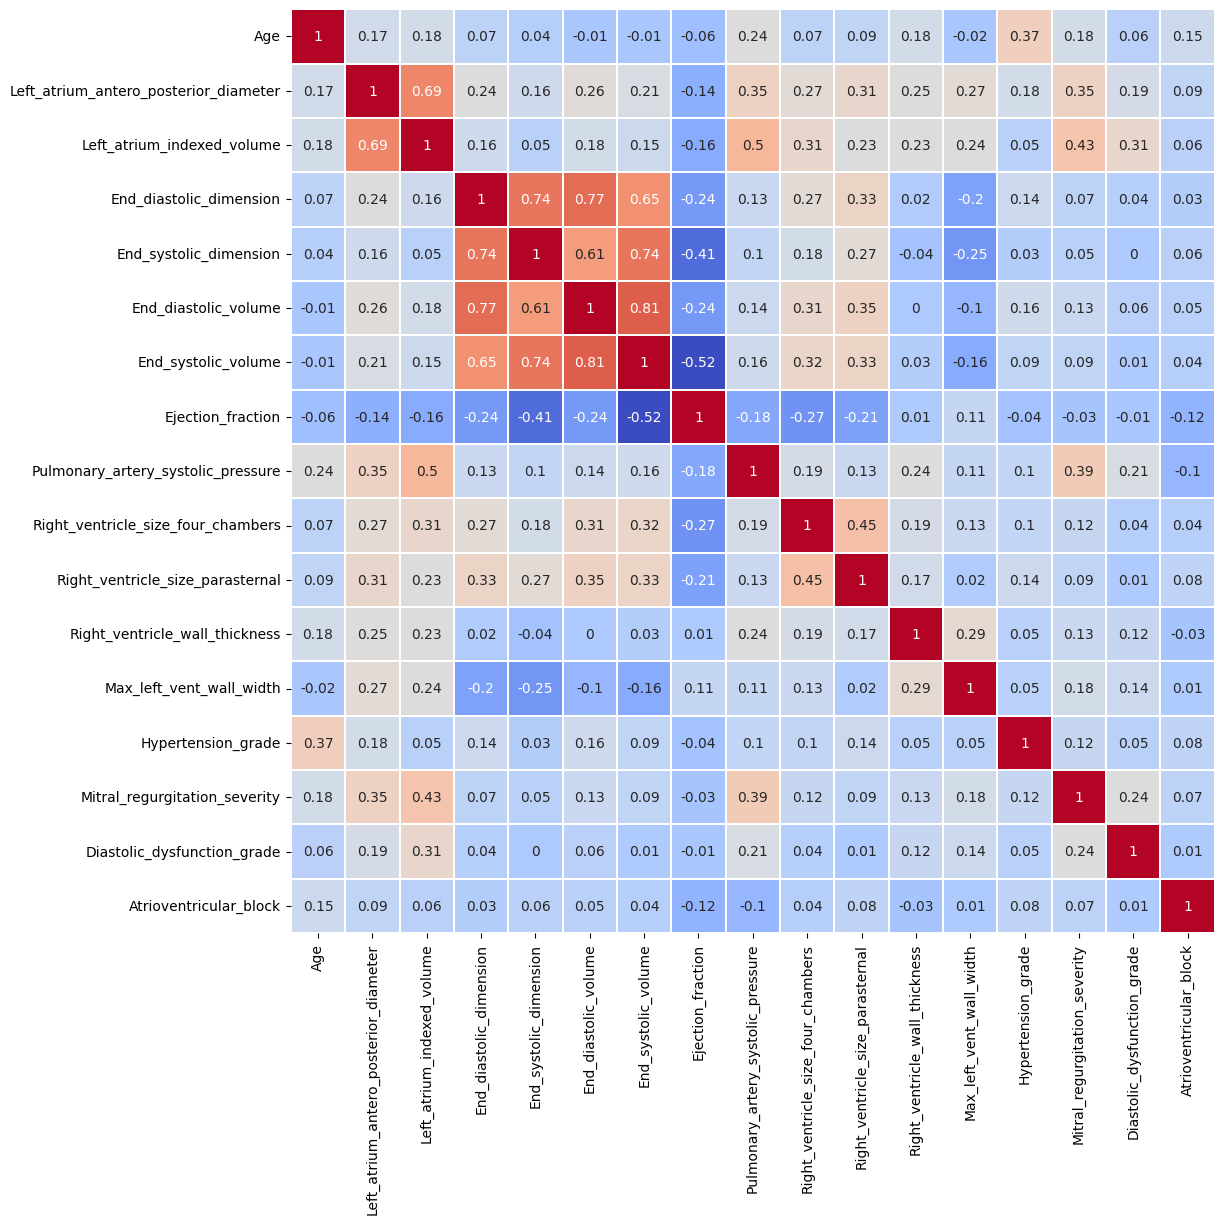

In [30]:
fig, ax = plt.subplots(figsize=(12,12))
sns.heatmap(round(clean_df[numerical_features+ordinal_features].corr(method='spearman'),2), annot=True, linewidths=.1, square=True, cmap="coolwarm", cbar=False)

In [31]:
noOutliers_df = clean_df[ordinal_features]
for column in clean_df[numerical_features].columns:
    #col = clean_df[column].dropna()
    col = clean_df[column]
    Q1 = col.quantile(0.25)
    Q3 = col.quantile(0.75)
    IQR = Q3 - Q1
    noOutliers_df[column] = col[~((col < (Q1 - 1.5 * IQR)) | (col > (Q3 + 1.5 * IQR)))]

In [32]:
clean_df

,HCM,Sex,Age,Dyspnoea_complaints,Chest_pain_complaints,Hypertension_grade,Arrhythmia_complaints,Syncope_complaints,Peripheral_oedema_complaints,Sudden_cardiac_death_anamnesis,...,Right_ventricle_wall_thickness,Mitral_valve,Aortic_valve,QRS_duration,Pathological_Q_wave,Atrial_fibrillation,Diabetes,Ventricular_tachycardia,Atrioventricular_block,Coronary_heart_disease
0,да,ж,42.0,да,да,NaN,нет,нет,нет,нет,...,NaN,недостаточность,норма,NaN,NaN,нет,нет,нет,0.0,нет
2,да,м,38.0,нет,да,0.0,нет,нет,нет,нет,...,3.0,норма,норма,NaN,NaN,нет,нет,нет,NaN,стенокардия
3,да,м,26.0,нет,нет,0.0,нет,нет,нет,нет,...,3.0,норма,норма,NaN,NaN,нет,нет,нет,2.0,нет
7,да,ж,67.0,да,да,3.0,да,пресинкопальные,да,нет,...,NaN,недостаточность,недостаточность,NaN,NaN,да,нет,нет,0.0,стенокардия
9,да,ж,60.0,да,да,3.0,нет,нет,да,нет,...,NaN,норма,норма,более 120 мсек,нет,нет,второго типа,нет,1.0,стенокардия
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1163,да,ж,70.0,да,да,2.0,да,синкопальные,нет,нет,...,5.0,недостаточность,норма,менее 120 мсек,нет,да,нет,нет,0.0,нет
1164,да,ж,74.0,нет,да,2.0,нет,нет,нет,нет,...,NaN,NaN,NaN,NaN,NaN,нет,нет,нет,0.0,прочее
1165,да,ж,55.0,да,да,2.0,да,синкопальные,нет,нет,...,NaN,недостаточность,норма,более 120 мсек,нет,да,первого типа,устойчивая,1.0,стенокардия+ПИКС
1166,да,м,47.0,да,нет,3.0,нет,нет,нет,нет,...,3.0,норма,норма,менее 120 мсек,нет,нет,нет,нет,0.0,нет


In [33]:
noOutliers_df

,Hypertension_grade,Mitral_regurgitation_severity,Diastolic_dysfunction_grade,Atrioventricular_block,Age,Left_atrium_antero_posterior_diameter,Left_atrium_indexed_volume,End_diastolic_dimension,End_systolic_dimension,End_diastolic_volume,End_systolic_volume,Ejection_fraction,Рulmonary_artery_systolic_pressure,Right_ventricle_size_four_chambers,Right_ventricle_size_parasternal,Right_ventricle_wall_thickness,Max_left_vent_wall_width
0,NaN,1.0,1.0,0.0,42.0,49.0,47.0,45.0,26.0,125.0,59.0,55.0,39.0,31.0,30.0,NaN,20.0
2,0.0,1.0,NaN,NaN,38.0,43.0,30.0,43.0,27.0,85.0,27.0,59.0,42.0,30.0,27.0,3.0,21.0
3,0.0,1.0,0.0,2.0,26.0,39.0,37.0,40.0,22.0,70.0,17.0,69.0,33.0,27.0,22.0,3.0,20.0
7,3.0,1.0,1.0,0.0,67.0,45.0,48.0,52.0,NaN,137.0,NaN,47.0,42.0,39.0,NaN,NaN,24.0
9,3.0,1.0,1.0,1.0,60.0,46.0,47.0,43.0,28.0,117.0,46.0,65.0,33.0,NaN,28.0,NaN,21.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1163,2.0,3.0,3.0,0.0,70.0,48.0,68.0,47.0,31.0,98.0,30.0,69.0,NaN,36.0,31.0,5.0,23.0
1164,2.0,NaN,NaN,0.0,74.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.0
1165,2.0,2.0,NaN,1.0,55.0,52.0,NaN,48.0,36.0,NaN,NaN,NaN,33.0,NaN,31.0,NaN,22.0
1166,3.0,1.0,2.0,0.0,47.0,46.0,29.0,45.0,30.0,91.0,34.0,NaN,21.0,NaN,25.0,3.0,20.0


In [34]:
clean_df['Atrioventricular_block'].value_counts()

Atrioventricular_block
0.0    419
1.0     75
2.0     19
3.0      5
Name: count, dtype: int64

In [35]:
noOutliers_df['Atrioventricular_block'].value_counts()

Atrioventricular_block
0.0    419
1.0     75
2.0     19
3.0      5
Name: count, dtype: int64

In [36]:
noOutliers_df.corr()

,Hypertension_grade,Mitral_regurgitation_severity,Diastolic_dysfunction_grade,Atrioventricular_block,Age,Left_atrium_antero_posterior_diameter,Left_atrium_indexed_volume,End_diastolic_dimension,End_systolic_dimension,End_diastolic_volume,End_systolic_volume,Ejection_fraction,Рulmonary_artery_systolic_pressure,Right_ventricle_size_four_chambers,Right_ventricle_size_parasternal,Right_ventricle_wall_thickness,Max_left_vent_wall_width
Hypertension_grade,1.000000,0.113211,0.051963,0.063623,0.421606,0.186911,0.065887,0.145020,0.016240,0.156780,0.065048,-0.061313,0.094037,0.104145,0.116681,0.089201,0.049881
Mitral_regurgitation_severity,0.113211,1.000000,0.264040,0.078233,0.185970,0.327350,0.391453,0.057607,0.000574,0.109549,0.066336,0.023763,0.359035,0.112730,0.078450,0.167602,0.185457
Diastolic_dysfunction_grade,0.051963,0.264040,1.000000,0.019786,0.066435,0.196938,0.309793,0.044065,0.015956,0.081894,0.034354,-0.038992,0.230658,0.013997,0.050157,0.152235,0.130136
Atrioventricular_block,0.063623,0.078233,0.019786,1.000000,0.121309,0.105574,0.023809,0.049170,0.077805,0.069984,0.084064,-0.101389,-0.062647,0.037153,0.024875,0.015921,-0.009905
Age,0.421606,0.185970,0.066435,0.121309,1.000000,0.183200,0.205144,0.099817,0.045781,0.016909,0.008360,-0.068940,0.225223,0.052191,0.076953,0.251222,0.017752
Left_atrium_antero_posterior_diameter,0.186911,0.327350,0.196938,0.105574,0.183200,1.000000,0.641422,0.208183,0.069767,0.214069,0.137969,-0.101977,0.313921,0.249427,0.274279,0.245975,0.269005
Left_atrium_indexed_volume,0.065887,0.391453,0.309793,0.023809,0.205144,0.641422,1.000000,0.148904,0.001876,0.145432,0.104082,-0.090028,0.495182,0.262689,0.184386,0.233721,0.235954
End_diastolic_dimension,0.145020,0.057607,0.044065,0.049170,0.099817,0.208183,0.148904,1.000000,0.721575,0.762480,0.602318,-0.209264,0.147637,0.262861,0.286600,0.059908,-0.190903
End_systolic_dimension,0.016240,0.000574,0.015956,0.077805,0.045781,0.069767,0.001876,0.721575,1.000000,0.590825,0.715388,-0.372127,0.064238,0.171002,0.250278,0.012595,-0.184874
End_diastolic_volume,0.156780,0.109549,0.081894,0.069984,0.016909,0.214069,0.145432,0.762480,0.590825,1.000000,0.788132,-0.196571,0.120651,0.307722,0.290120,-0.000008,-0.097476


<Axes: >

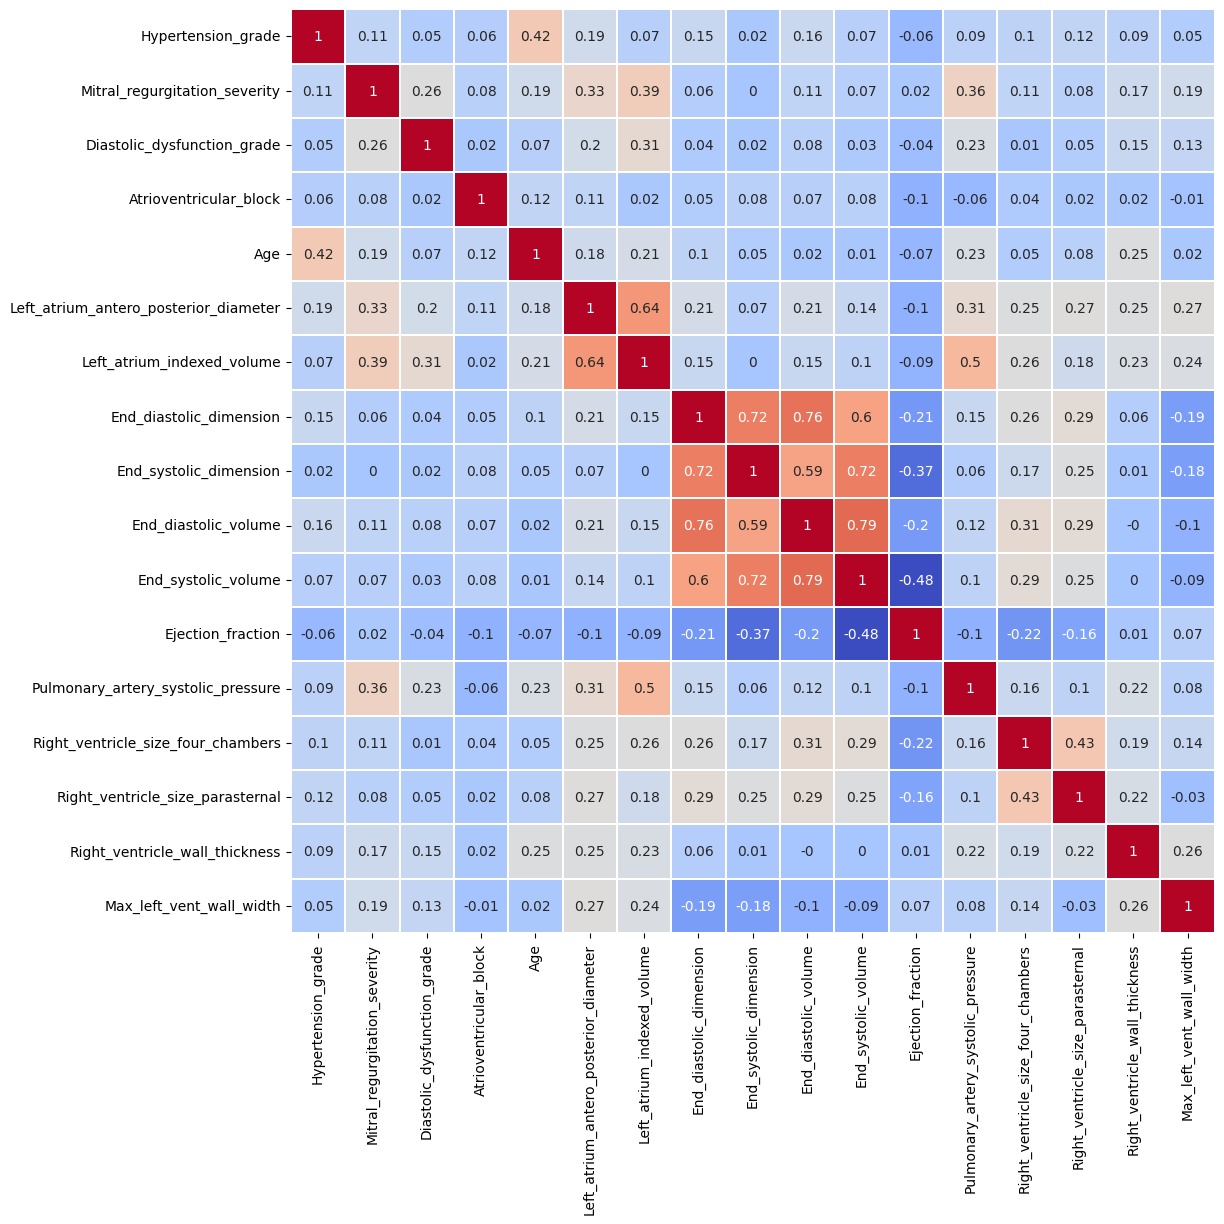

In [37]:
plt.subplots(figsize=(12,12))
sns.heatmap(round(noOutliers_df.corr(),2), annot=True, linewidths=.1, square=True, cmap="coolwarm", cbar=False)

<Axes: >

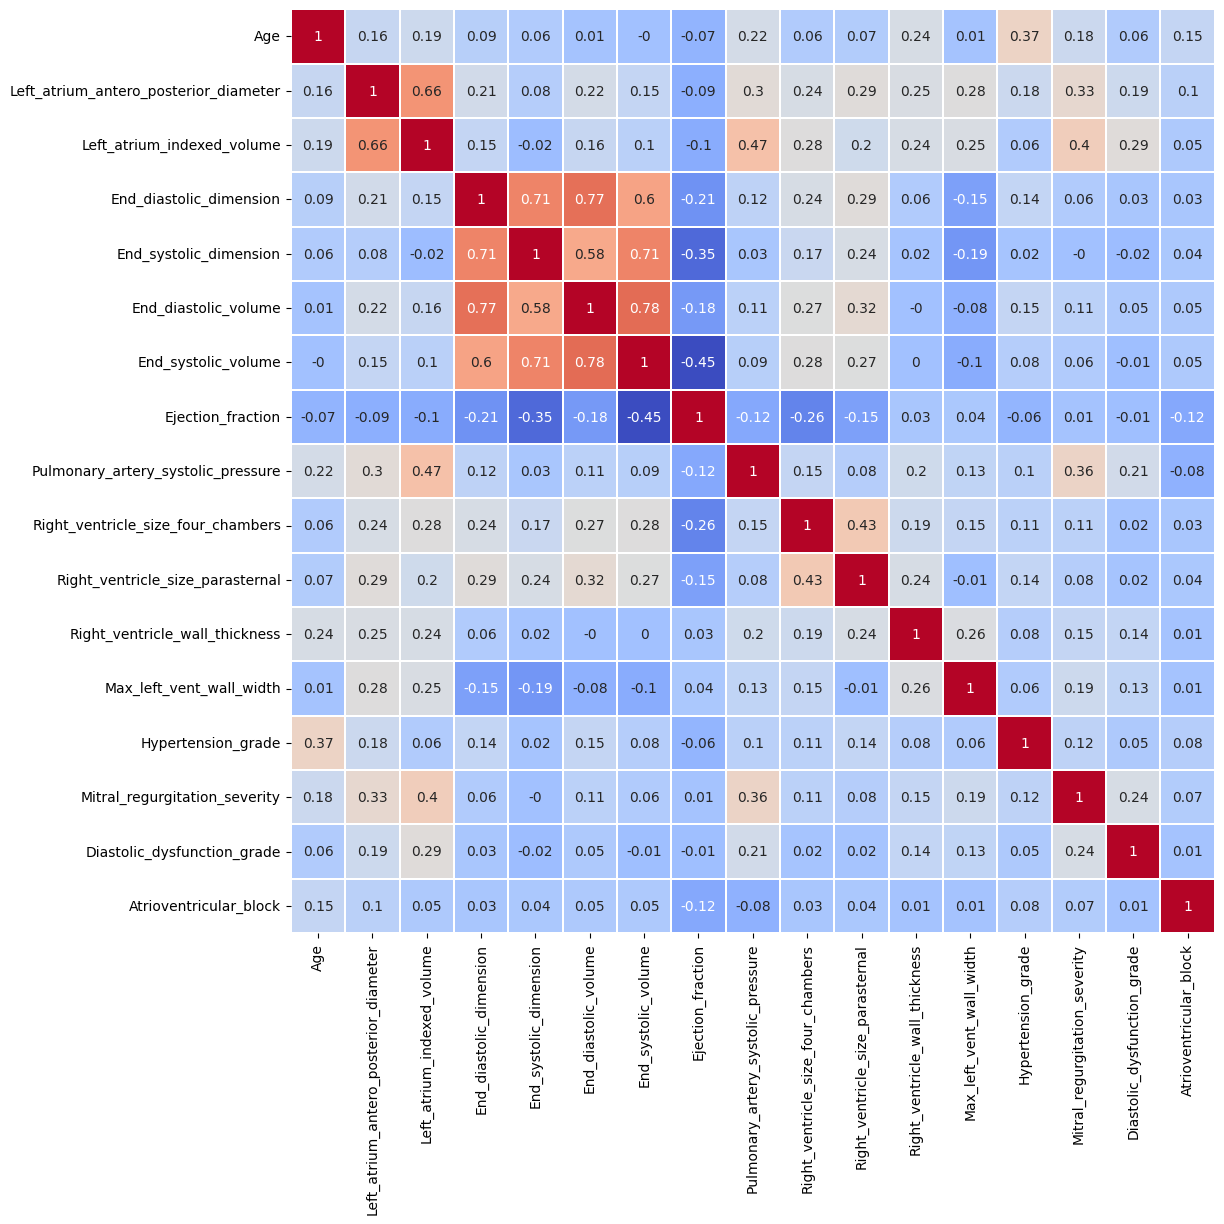

In [38]:
plt.subplots(figsize=(12,12))
sns.heatmap(round(noOutliers_df[numerical_features+ordinal_features].corr(method='spearman'),2), annot=True, linewidths=.1, square=True, cmap="coolwarm", cbar=False)

<Axes: >

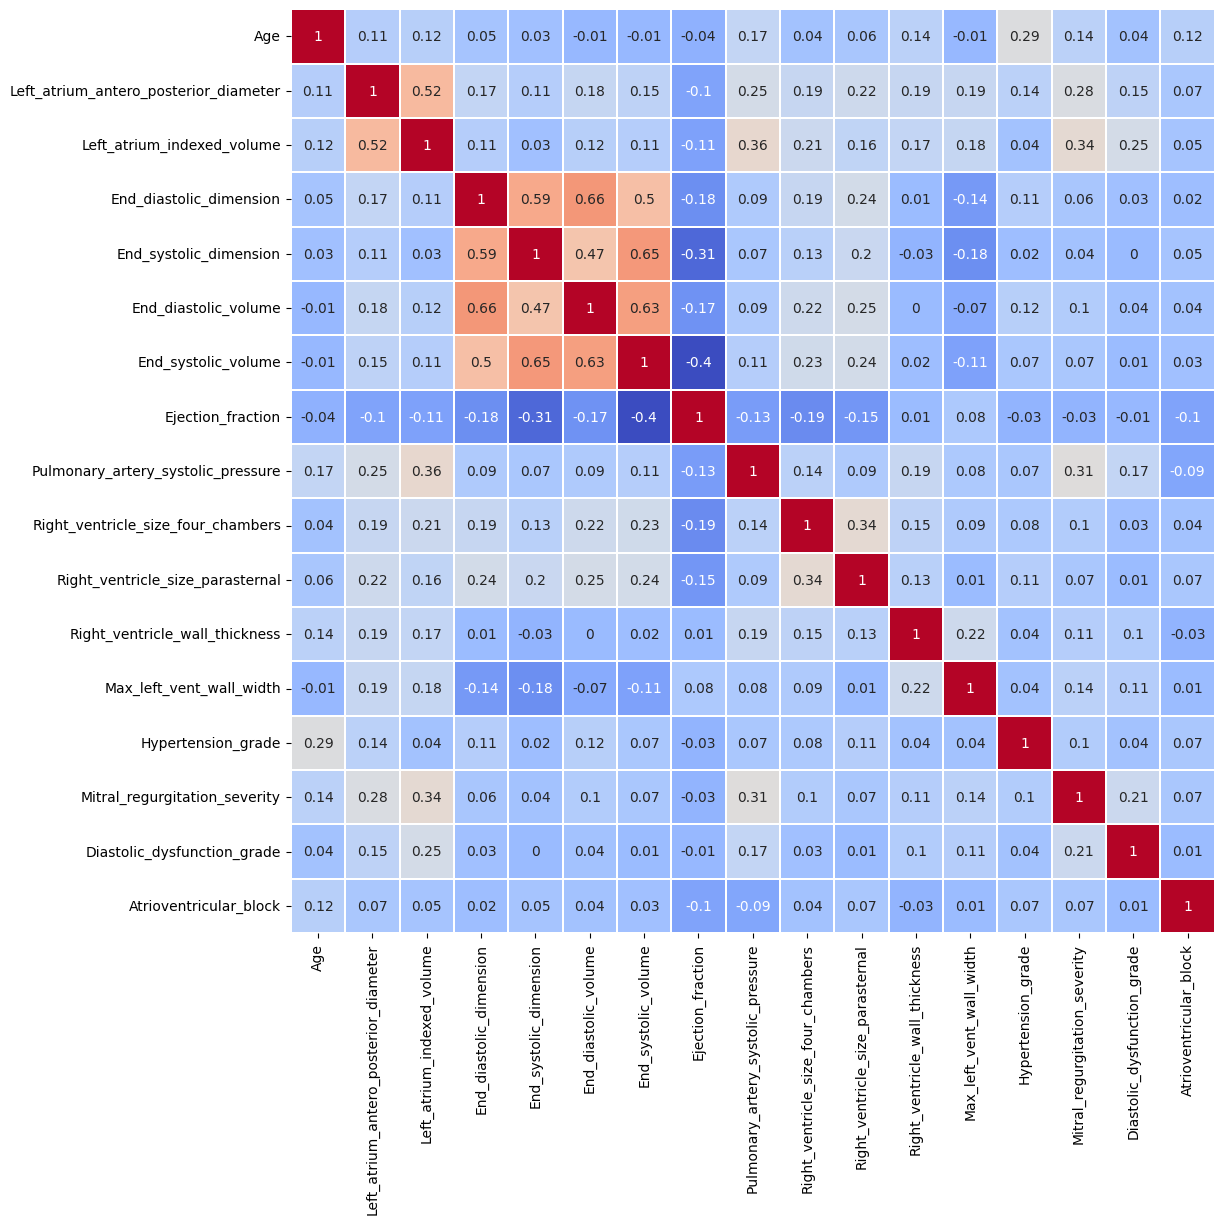

In [39]:
plt.subplots(figsize=(12,12))
sns.heatmap(round(clean_df[numerical_features+ordinal_features].corr(method='kendall'),2), annot=True, linewidths=.1, square=True, cmap="coolwarm", cbar=False)

<Axes: >

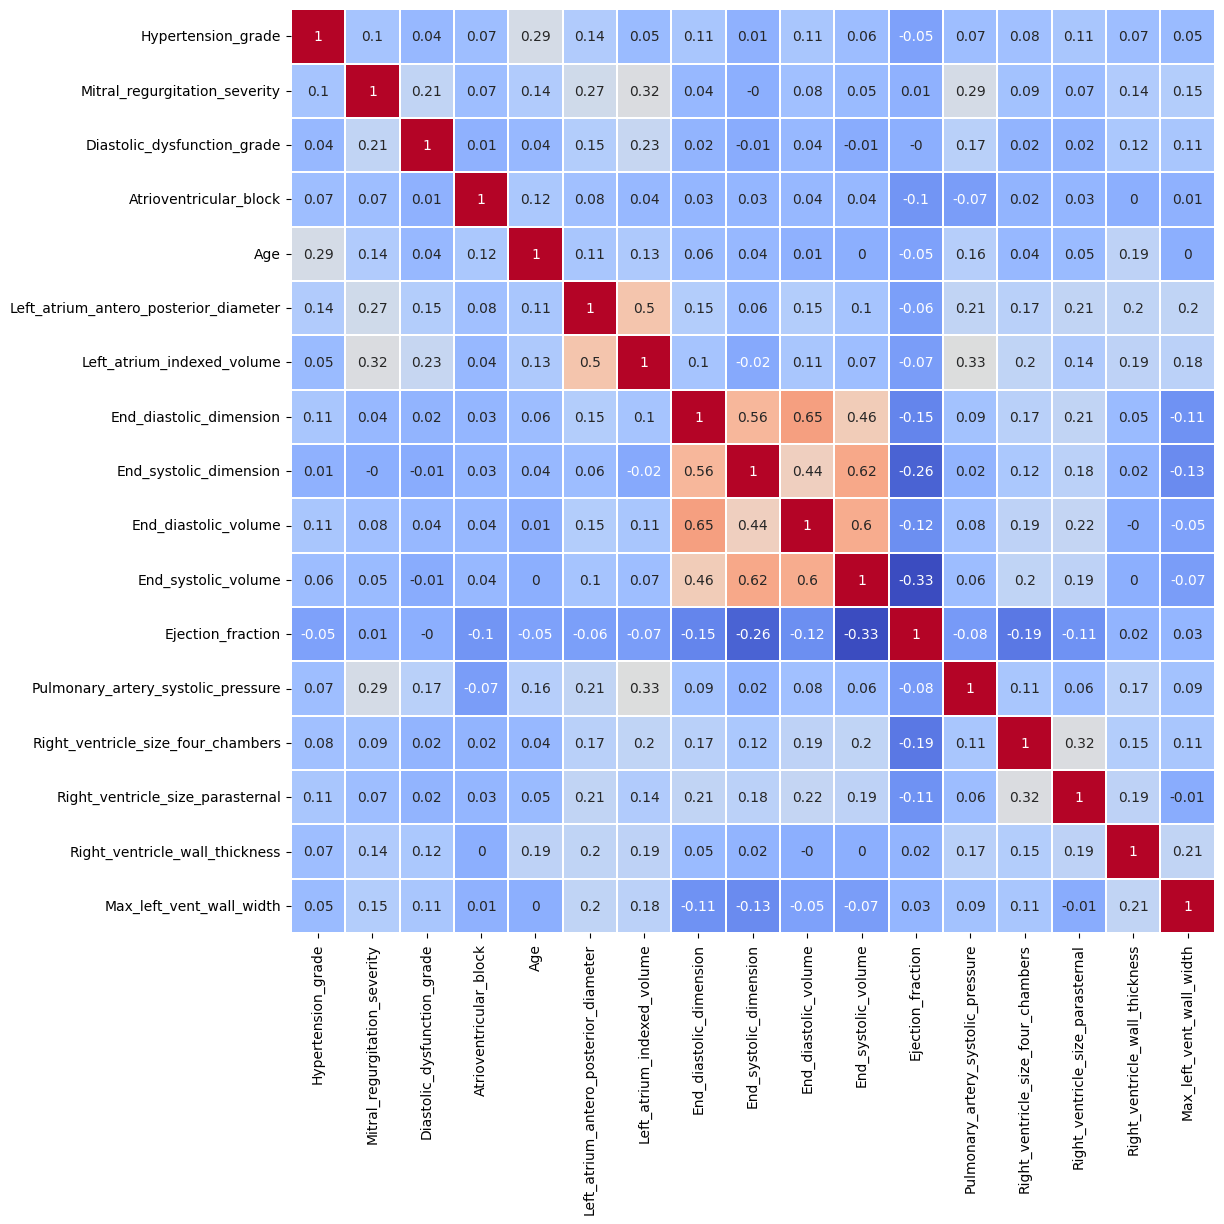

In [40]:
plt.subplots(figsize=(12,12))
sns.heatmap(round(noOutliers_df.corr(method='kendall'),2), annot=True, linewidths=.1, square=True, cmap="coolwarm", cbar=False)